# Image Search

<b>The idea of Approach is to Built an pipeline to get Nearest search of input images</b>
The Algorithm Mainly divided into 3 parts explained below in Diagram and 
<li>AutoEncoder: To get bottleneck features from images</li>
<li>Kmean: To create cluster labels for KNN algorithm</li>
<li>KNN: Building model to give N nearest recommendation </li>
DataSet: </br>
https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html </br>
https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg</br>

![title](dig.png)

In [6]:
import pandas as pd
import numpy as np,os
from sklearn.manifold import TSNE
import tensorflow as tf
import cv2,PIL,tqdm
from sklearn.manifold import TSNE
#For model performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
#For model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from random import shuffle
import random
#from tensorflow.keras.layers.BatchNormalization import BatchNormalization
#from tensorflow.keras.layers.BatchNormalization import BatchNormalization
import matplotlib.pyplot as plt
path = '/media/ricky/data/dataset/celeb/annotation/Anno/list_attr_celeba.txt'
image_path = '/media/ricky/data/dataset/celeb/img_align_celeba/img_align_celeba/'

<h2> Data Loading</h2>

In [7]:
features=[]
raw=[]
with open(path) as file:
    print(file.readline())
    print(file.readline().split())
    for line in file:
        features.append([max(0,float(x)) for x in line.split()[1:]])
        raw.append(line.split())
raw = np.array(raw)

202599

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


<h2>Data Loader and Test Train Split </h2>

In [8]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, samples,
                 batch_size,image_path,
                 input_size=(192, 192, 3),
                 shuffle=True):
        self.image_path =image_path
        self.samples = samples
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(samples)
    
    def on_epoch_end(self):
        if self.shuffle:
            from random import shuffle
            shuffle(self.samples)
            #self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path, bbox, target_size):
    
        xmin, ymin, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']

        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = image_arr[ymin:ymin+h, xmin:xmin+w]
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

        return image_arr/255.
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        X_train = []
        y_train = []

            # For each example
        for batch_sample in batches:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                #label = batch_sample[1]
                img =  cv2.imread(os.path.join(self.image_path,img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (self.input_size[0],self.input_size[1]))
                #print(os.path.join(image_path,img_name))
                
                # apply any kind of preprocessing
                #img,label = preprocessing(img,label)
                # Add example to arrays
                X_train.append(img)
                y_train.append(img)
        X_train = np.array(X_train).astype('float32')/255.0
        y_train = np.array(y_train).astype('float32')/255.0
       
        return X_train, y_train
    
    def __getitem__(self, index):
        
        batch_samples = self.samples[index:index+self.batch_size]
        X, y = self.__get_data(batch_samples)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size
    


In [9]:
sample = list(raw[:,:1])
shuffle(sample)
train,test = train_test_split(sample, test_size=0.20, random_state=6)

val = test[:2000]

dataTrain = CustomDataGen(train,8,image_path)
datatest = CustomDataGen(test,8,image_path)

dataval = CustomDataGen(val,8,image_path)

len(train),len(test),len(val)

(162079, 40520, 2000)

# **AutoEncoder & Model Training:**

In [3]:
def getModel():

    #Encoder 
    model = Sequential(name='AutoEncoder_Model')
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(192, 192, 3),padding='same', name='E_Conv2D_1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='E_MaxPooling2D_1'))
    model.add(Conv2D(128, kernel_size=(3, 3),strides=1,activation='relu',padding='same', name='E_Conv2D_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='E_MaxPooling2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='E_Conv2D_3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='E_MaxPooling2D_3'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='E_Conv2D_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='E_MaxPooling2D_4'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='E_Conv2D_5'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
    
    #Decoder
    model.add(Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', name='Decoding_Conv2D_1'))
    model.add(UpSampling2D((2, 2), name='D_Upsamping2D_1'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='D_Conv2D_2'))
    model.add(UpSampling2D((2, 2), name='D_Upsamping2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',name='D_Conv2D_3'))
    model.add(UpSampling2D((2, 2),name='D_Upsamping2D_3'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',name='D_Conv2D_4'))
    model.add(UpSampling2D((2, 2),name='D_Upsamping2D_4'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',name='D_Conv2D_5'))
    model.add(UpSampling2D((2, 2),name='D_Upsamping2D_5'))
    model.add(Conv2D(3, kernel_size=(3, 3), padding='same',activation='sigmoid',name='D_Output'))
    return model
model = getModel()
model.load_weights('encoder_model.h5')

In [ ]:

INIT_LR = 1e-3
EPOCHS  =5
optimizer = Adam(learning_rate=INIT_LR,amsgrad=True,decay=INIT_LR/EPOCHS)
model.compile(optimizer=optimizer, loss='mse')
#model.load_weights('encoder_model.h5')
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=3,min_delta=0.0001) 
checkpoint = ModelCheckpoint('encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
history = model.fit(dataTrain, epochs=EPOCHS, batch_size=8,validation_data=dataval,callbacks=[early_stopping,checkpoint])


In [10]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='r'):
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

# Sample Output

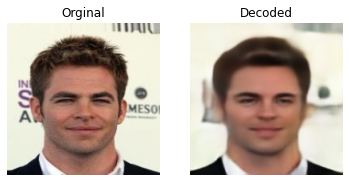

In [12]:
sample_image =  cv2.imread(os.path.join(image_path,test[100][0]))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (192,192))

sample_image = np.expand_dims(sample_image,axis=0).astype('float32')/255.0
image = model.predict(sample_image)
plot_(sample_image[0,:,:,:],'','',1,2,1,"Orginal","","","",True)
plot_(image[0,:,:],'','',1,2,2,"Decoded","","","",True)
plt.show()

# Feature Extraction 

In [7]:
from tensorflow.keras.models import Model
encoder = Model(inputs=model.input,
	outputs=model.get_layer("Decoding_Conv2D_1").output)
encoder.output

<tf.Tensor 'Decoding_Conv2D_1/Identity:0' shape=(None, 6, 6, 512) dtype=float32>

In [21]:
def data_generator(samples, batch_size=8,shuffle_data=False,resize=192):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    count =0 
    for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]
            count=count+offset+batch_size
            #print(count,num_samples)
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                #label = batch_sample[1]
                img =  cv2.imread(os.path.join(image_path,img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (resize,resize))
                #print(os.path.join(image_path,img_name))
                
                # apply any kind of preprocessing
                #img,label = preprocessing(img,label)
                # Add example to arrays
                X_train.append(img)
                #y_train.append(img)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train).astype('float32')/255.0
      
            
            yield X_train#, y_train

<h2>Feature Extraction from bottleneck</h2>
<li> Decoded image are compressed representation takes 8 times less space to original image.</li>
NOTE :  For Demo only 50k features been extracted

In [22]:
count=0
gen = data_generator(list( raw[:50000,:1]),32)
X_encoded = []
for x in gen:
    #print(i.shape,y.shape)
    X_encoded.append(encoder.predict(x))
    
X_encoded = np.concatenate(X_encoded)
X_encoded.shape


(50000, 6, 6, 512)

In [23]:
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2]*X_encoded.shape[3])
print(X_encoded_reshape.shape)
np.save('X_encoded.npy',X_encoded_reshape)

(50000, 18432)


In [3]:
X_encoded_reshape = np.load('X_encoded.npy')
X_encoded_reshape.shape

(50000, 18432)

In [4]:
features = np.array(features)
features.shape

(202599, 40)

# Feature Concationation 
<li> Features extracted from <b>images</b> been concatenated with features from <b>list_attr_celeba.txt</b> </li>

In [6]:
merge = np.concatenate((X_encoded_reshape, features[:50000,:]), axis=1)
np.save('merge_encoded.npy',merge)

In [8]:
merge[:1000,:].shape

(1000, 18472)

# **Clustering Image Data + Features**
Detail cluster Analysis can be found in **cluster_analysis.ipynb**</br>
**Note:** 10k samples used demo approach (Memory Constraints :-))

In [115]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, algorithm = 'auto').fit(merge[:10000,:])
#kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto').fit(data)
kmeans.labels_

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [150]:
clusterSample = merge[:10000,:]
labels=[]
data=[]
files=[]
for idx,i in enumerate(clusterSample):
    data.append(i)
    labels.append(kmeans.labels_[idx])
 
print(np.array(labels).shape)
print(np.array(data).shape)
#print(np.array(files).shape)


(10000,)
(10000, 18472)


#  KNN Model to find Nearest Nieghbours

In [123]:
knn = KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree',n_jobs=-1)
knn.fit(np.array(data),np.array(labels))

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1)

In [122]:
import joblib
knn_file = 'knn_model.pkl'
joblib.dump(knn,knn_file)
#knn2=joblib.load(knn_file)

['knn_model.pkl']

# **Predict N similar Images**

In [152]:
def recommend(query,result):

    def read(img):
        image = cv2.imread(image_path+img)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        return image
    plt.figure(figsize=(10,5))
    if type(query)!=type(30):
        plot_(query,"","",1,1,1,"Query Image","","","",True)
    else:
        plot_(read(raw[query][0]),"","",1,1,1,"Query Image "+raw[query][0],"","","",True)
    plt.show()
    plt.figure(figsize=(20,5))
    for iter,i in enumerate(result):
        plot_(read(raw[i][0]),"","",1,len(result),iter+1,raw[i][0],"","","",True)
    plt.show()

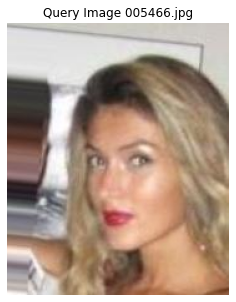

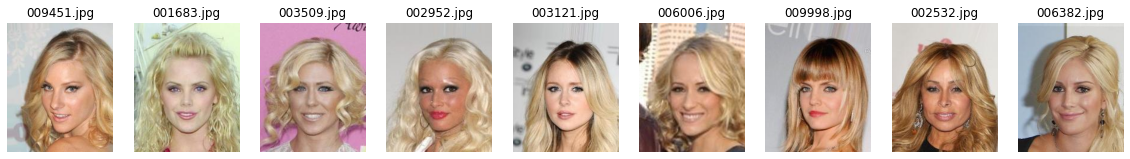

In [153]:
num = 5465 #datapoint
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=10)
recommend(num,list(res[1][0])[1:])

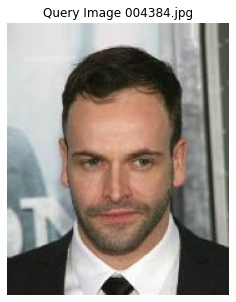

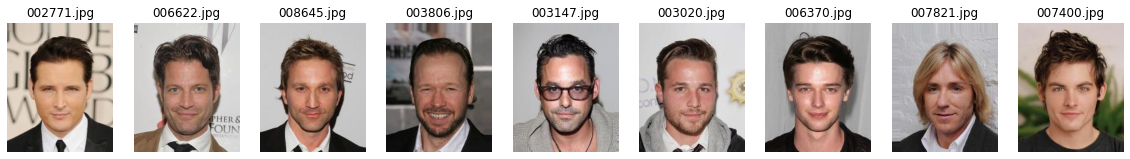

In [126]:
num = 4383
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=10)
recommend(num,list(res[1][0])[1:])

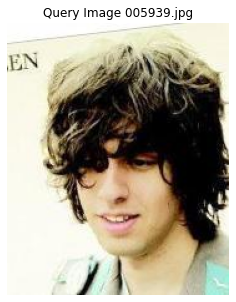

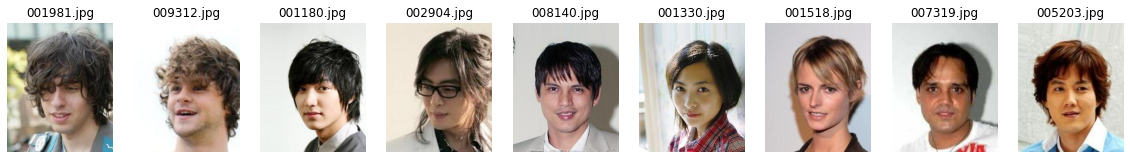

In [127]:
num = 5938
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=10)
recommend(num,list(res[1][0])[1:])

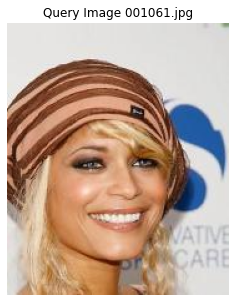

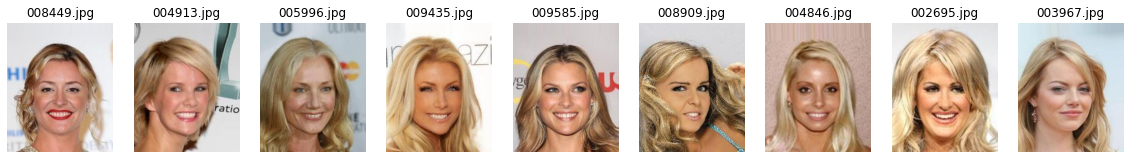

In [131]:
num = 1060
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=10)
recommend(num,list(res[1][0])[1:])

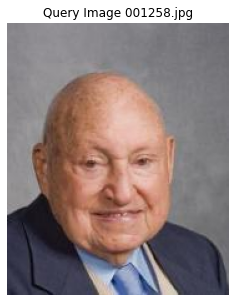

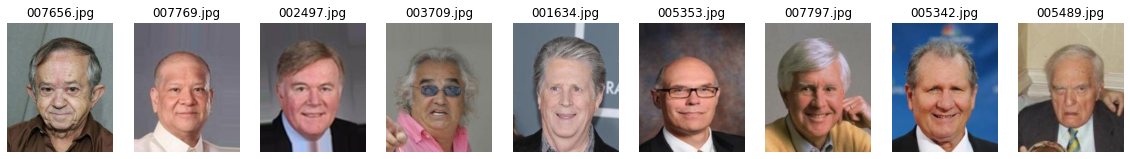

In [147]:
num = 1257
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=10)
recommend(num,list(res[1][0])[1:])

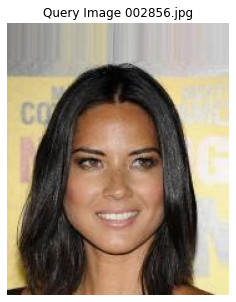

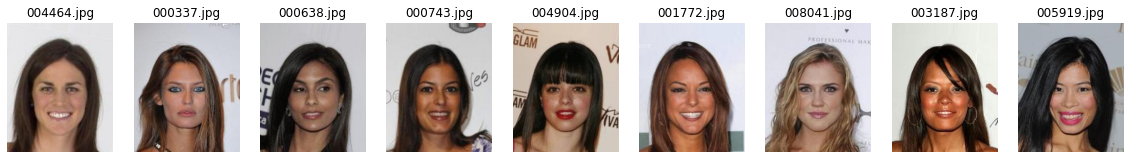

In [132]:
num = 2855
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=10)
recommend(num,list(res[1][0])[1:])

# Adios